In [1]:
!cp -r ../input/recsys-repo/RecSys_Course_AT_PoliMi-master/* ./

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from urllib.request import urlretrieve
import zipfile, os
import scipy.sparse as sps
import matplotlib.pyplot as pyplot
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
## In order to evaluate put it in a recommender class
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.Recommender_utils import check_matrix
from sklearn.linear_model import ElasticNet
from Recommenders.BaseSimilarityMatrixRecommender import BaseItemSimilarityMatrixRecommender
from Utils.seconds_to_biggest_unit import seconds_to_biggest_unit
import time, sys
from tqdm import tqdm
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from lightfm import LightFM
URM_path = "../input/urm-true-binary/URM_True_Binary.csv"
URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path, 
                                sep=",",
                                dtype={0:int, 1:int, 2:float},
                                header=0)
URM_all_dataframe.columns = ["UserID", "ItemID", "Data"]
URM_all = sps.coo_matrix((URM_all_dataframe["Data"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)))
URM_all = URM_all.tocsr() # to obtain fast access to rows (users)

In [2]:
!python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorization_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from MatrixFactorization_Cython_Epoch.c:746:
/opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorization_Cython_Epoch.c: In function ‘__pyx_pf_32MatrixFactorization_Cyth

In [3]:
!zip -r -j /kaggle/working/SLIMElasticNetRecommender.zip /kaggle/input/slimurmbinary/W_sparse.npz

  adding: W_sparse.npz (deflated 0%)


In [4]:
URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.8)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])


EvaluatorHoldout: Ignoring 780 ( 1.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 317 ( 0.8%) Users that have less than 1 test interactions


In [5]:
URM_train

<41629x24507 sparse matrix of type '<class 'numpy.float64'>'
	with 994970 stored elements in Compressed Sparse Row format>

In [6]:
sps.csr_matrix(URM_train)

<41629x24507 sparse matrix of type '<class 'numpy.float64'>'
	with 994970 stored elements in Compressed Sparse Row format>

In [7]:
sps.csr_matrix(URM_train).indptr

array([     0,     39,     54, ..., 994916, 994951, 994970], dtype=int32)

In [8]:
profile_length = np.ediff1d(sps.csr_matrix(URM_train).indptr)
profile_length, profile_length.shape

(array([39, 15, 67, ..., 13, 35, 19], dtype=int32), (41629,))

In [9]:
block_size = int(len(profile_length)*0.05)
block_size

2081

In [10]:
sorted_users = np.argsort(profile_length)
sorted_users

array([28014, 12070, 38033, ..., 19407,  8693, 12454])

In [11]:
for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    

Group 0, #users in group 2081, average p.len 7.31, median 8.0, min 2, max 9
Group 1, #users in group 2081, average p.len 9.64, median 10.0, min 9, max 10
Group 2, #users in group 2081, average p.len 10.92, median 11.0, min 10, max 12
Group 3, #users in group 2081, average p.len 12.05, median 12.0, min 12, max 13
Group 4, #users in group 2081, average p.len 13.00, median 13.0, min 13, max 13
Group 5, #users in group 2081, average p.len 13.96, median 14.0, min 13, max 14
Group 6, #users in group 2081, average p.len 14.91, median 15.0, min 14, max 15
Group 7, #users in group 2081, average p.len 15.81, median 16.0, min 15, max 16
Group 8, #users in group 2081, average p.len 16.81, median 17.0, min 16, max 17
Group 9, #users in group 2081, average p.len 17.83, median 18.0, min 17, max 18
Group 10, #users in group 2081, average p.len 19.07, median 19.0, min 18, max 20
Group 11, #users in group 2081, average p.len 20.40, median 20.0, min 20, max 21
Group 12, #users in group 2081, average p.le

In [12]:
class SLIMElasticNetRecommender(BaseItemSimilarityMatrixRecommender):
    """
    Train a Sparse Linear Methods (SLIM) item similarity model.
    NOTE: ElasticNet solver is parallel, a single intance of SLIM_ElasticNet will
          make use of half the cores available
    See:
        Efficient Top-N Recommendation by Linear Regression,
        M. Levy and K. Jack, LSRS workshop at RecSys 2013.
        SLIM: Sparse linear methods for top-n recommender systems,
        X. Ning and G. Karypis, ICDM 2011.
        http://glaros.dtc.umn.edu/gkhome/fetch/papers/SLIM2011icdm.pdf
    """

    RECOMMENDER_NAME = "SLIMElasticNetRecommender"

    def __init__(self, URM_train, verbose = True):
        super(SLIMElasticNetRecommender, self).__init__(URM_train, verbose = verbose)

    @ignore_warnings(category=ConvergenceWarning)
    def fit(self, l1_ratio=0.1, alpha = 1.0, positive_only=True, topK = 100,**earlystopping_kwargs):

        assert l1_ratio>= 0 and l1_ratio<=1, "{}: l1_ratio must be between 0 and 1, provided value was {}".format(self.RECOMMENDER_NAME, l1_ratio)

        self.l1_ratio = l1_ratio
        self.positive_only = positive_only
        self.topK = topK


        # initialize the ElasticNet model
        self.model = ElasticNet(alpha=alpha,
                                l1_ratio=self.l1_ratio,
                                positive=self.positive_only,
                                fit_intercept=False,
                                copy_X=False,
                                precompute=True,
                                selection='random',
                                max_iter=100,
                                tol=1e-4)

        URM_train = check_matrix(self.URM_train, 'csc', dtype=np.float32)

        n_items = URM_train.shape[1]

        # Use array as it reduces memory requirements compared to lists
        dataBlock = 10000000

        rows = np.zeros(dataBlock, dtype=np.int32)
        cols = np.zeros(dataBlock, dtype=np.int32)
        values = np.zeros(dataBlock, dtype=np.float32)

        numCells = 0

        start_time = time.time()
        start_time_printBatch = start_time

        # fit each item's factors sequentially (not in parallel)
        for currentItem in range(n_items):

            # get the target column
            y = URM_train[:, currentItem].toarray()

            # set the j-th column of X to zero
            start_pos = URM_train.indptr[currentItem]
            end_pos = URM_train.indptr[currentItem + 1]

            current_item_data_backup = URM_train.data[start_pos: end_pos].copy()
            URM_train.data[start_pos: end_pos] = 0.0

            # fit one ElasticNet model per column
            self.model.fit(URM_train, y)

            # self.model.coef_ contains the coefficient of the ElasticNet model
            # let's keep only the non-zero values

            # Select topK values
            # Sorting is done in three steps. Faster then plain np.argsort for higher number of items
            # - Partition the data to extract the set of relevant items
            # - Sort only the relevant items
            # - Get the original item index

            nonzero_model_coef_index = self.model.sparse_coef_.indices
            nonzero_model_coef_value = self.model.sparse_coef_.data

            local_topK = min(len(nonzero_model_coef_value)-1, self.topK)

            relevant_items_partition = (-nonzero_model_coef_value).argpartition(local_topK)[0:local_topK]
            relevant_items_partition_sorting = np.argsort(-nonzero_model_coef_value[relevant_items_partition])
            ranking = relevant_items_partition[relevant_items_partition_sorting]

            for index in range(len(ranking)):

                if numCells == len(rows):
                    rows = np.concatenate((rows, np.zeros(dataBlock, dtype=np.int32)))
                    cols = np.concatenate((cols, np.zeros(dataBlock, dtype=np.int32)))
                    values = np.concatenate((values, np.zeros(dataBlock, dtype=np.float32)))


                rows[numCells] = nonzero_model_coef_index[ranking[index]]
                cols[numCells] = currentItem
                values[numCells] = nonzero_model_coef_value[ranking[index]]

                numCells += 1

            # finally, replace the original values of the j-th column
            URM_train.data[start_pos:end_pos] = current_item_data_backup

            elapsed_time = time.time() - start_time
            new_time_value, new_time_unit = seconds_to_biggest_unit(elapsed_time)


            if time.time() - start_time_printBatch > 300 or currentItem == n_items-1:
                self._print("Processed {} ({:4.1f}%) in {:.2f} {}. Items per second: {:.2f}".format(
                    currentItem+1,
                    100.0* float(currentItem+1)/n_items,
                    new_time_value,
                    new_time_unit,
                    float(currentItem)/elapsed_time))

                sys.stdout.flush()
                sys.stderr.flush()

                start_time_printBatch = time.time()

        # generate the sparse weight matrix
        self.W_sparse = sps.csr_matrix((values[:numCells], (rows[:numCells], cols[:numCells])),
                                       shape=(n_items, n_items), dtype=np.float32)

In [13]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.KNN import ItemKNN_CFCBF_Hybrid_Recommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython, MatrixFactorization_FunkSVD_Cython, MatrixFactorization_AsySVD_Cython
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {
                                   "SLIMElasticNetRecommender": SLIMElasticNetRecommender,
                                   "TopPop": TopPop,
                                   "UserKNNCF": UserKNNCFRecommender,
                                   "ItemKNNCF": ItemKNNCFRecommender,
                                   "P3alpha": P3alphaRecommender,
                                   "RP3beta": RP3betaRecommender,
                                   "PureSVD": PureSVDRecommender,
                                   "NMF": NMFRecommender,
                                   "FunkSVD": MatrixFactorization_FunkSVD_Cython,
                                   "SLIMBPR": SLIM_BPR_Cython,
                                   }

content_recommender_class = {"ItemKNNCBF": ItemKNNCBFRecommender,
                             "ItemKNNCFCBF": ItemKNN_CFCBF_Hybrid_Recommender
                            }

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():
    recommender_object = recommender_class(URM_train)
    
    if isinstance(recommender_object, SLIMElasticNetRecommender):
        recommender_object.load_model("/kaggle/working")
    else:
         recommender_object.fit()
            
    recommender_object_dict[label] = recommender_object
    

SLIMElasticNetRecommender: Loading model from file '/kaggle/workingSLIMElasticNetRecommender'
SLIMElasticNetRecommender: Loading complete
Similarity column 41629 (100.0%), 1984.05 column/sec. Elapsed time 20.98 sec
Similarity column 24507 (100.0%), 4597.58 column/sec. Elapsed time 5.33 sec
P3alphaRecommender: Similarity column 24507 (100.0%), 2581.70 column/sec. Elapsed time 9.49 sec
RP3betaRecommender: Similarity column 24507 (100.0%), 2341.96 column/sec. Elapsed time 10.46 sec
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 3.53 sec
NMFRecommender: Computing NMF decomposition...
NMFRecommender: Computing NMF decomposition... done in 1.74 min
FUNK_SVD: Processed 995000 (100.0%) in 1.75 sec. MSE loss 4.35E-01. Sample per second: 568026
FUNK_SVD: Epoch 1 of 300. Elapsed time 1.52 sec
FUNK_SVD: Processed 995000 (100.0%) in 2.27 sec. MSE loss 6.02E-02. Sample per second: 437857
FUNK_SVD: Epoch 2 of 300. Elapsed time 3.04 sec
FU

In [14]:
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

Group 0, #users in group 2081, average p.len 7.31, median 8.0, min 2, max 9
EvaluatorHoldout: Ignoring 317 ( 0.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 2050 (100.0%) in 2.52 sec. Users per second: 814
EvaluatorHoldout: Processed 2050 (100.0%) in 2.74 sec. Users per second: 747
EvaluatorHoldout: Processed 2050 (100.0%) in 2.33 sec. Users per second: 879
EvaluatorHoldout: Processed 2050 (100.0%) in 2.39 sec. Users per second: 859
EvaluatorHoldout: Processed 2050 (100.0%) in 2.24 sec. Users per second: 916
EvaluatorHoldout: Processed 2050 (100.0%) in 2.24 sec. Users per second: 913
EvaluatorHoldout: Processed 2050 (100.0%) in 2.83 sec. Users per second: 723
EvaluatorHoldout: Processed 2050 (100.0%) in 4.66 sec. Users per second: 440
EvaluatorHoldout: Processed 2050 (100.0%) in 2.87 sec. Users per second: 715
EvaluatorHoldout: Processed 2050 (100.0%) in 2.35 sec. Users per second: 873
Group 1, #users in group 2081,

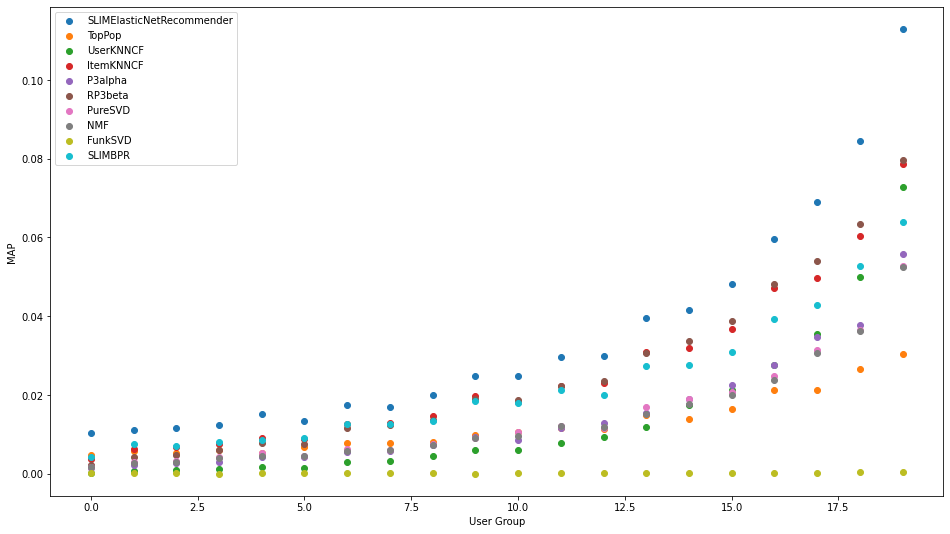

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()